# Machine Learning for Villena-Gonzalez CDA Study (2019)

In [4]:
import numpy as np
import glob
import pickle
import pandas as pd

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/')
from events import get_specific_events, get_epochs, get_CDA
from events import prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
 
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
#==================================================================
# General Variables
#==================================================================
study_id = 'Villena2019'

triggers = dict();

triggers['1'] = [10,11,12,13] 
triggers['2'] = [20,21,22,23]
triggers['4'] = [40,41,42,43]

triggers['left'] =  [10,13,20,23,40,43] #[11,12,21,22,41,42]
triggers['right'] = [11,12,21,22,41,42] #[10,13,20,23,40,43]

triggers['good'] = [60]
triggers['bad'] =  [61]
# --------------------------

# Labels
conds = ['1', '2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# Internal Triggers to Epochs Properly
internal_triggers = dict()
internal_triggers_count = 0
for cond in conds:
    for side in sides:
        for perf in perfs:
            internal_triggers_count = internal_triggers_count + 1
            internal_triggers['{}-{}-{}'.format(cond,side,perf)] = internal_triggers_count
            
# CDA Channels
#chan_right = ['TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
#chan_left =  ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
chan_left =  ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
chan_right = ['Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

# Epoch information
epoch_length = 1.2
epoch_tmin = -0.4
baseline_corr = (-0.4, -0.2)

# CDA info
cda_window = (0.3, 0.9)

# CDA main variable!
cda_dict_all = dict()
epochs_dict_all = dict()
perf_report_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Villena-Gonzalez 2019\\Data\\'
directory_path = '/Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/'
sep = '/'

filepath = directory_path + 'AP140119.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind(sep)+1:]
print('Processing: ' + filename + '...')

# ------------------------
# 1. -- Load File --
# ------------------------
raw = read_raw_bdf(filepath, preload=True)

# ------------------------
# 2. -- Preprocessing --
# ------------------------
# Keep only EEG channels and reference
#raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG4','EXG5','EXG6'])
raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])
raw = raw.set_channel_types({'EXG7': 'misc', 'EXG8': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Resample
preproc = raw.resample(1024)

# Filter
preproc = preproc.filter(.1, 80, fir_design='firwin', skip_by_annotation='edge')

# Events
events = find_events(preproc)

# Chan Pairs
chan_pairs = ['{}-{}'.format(chan_right[i], chan_left[i]) for i, chan in enumerate(chan_right)]

for i, chan in enumerate(chan_right):
    preproc = mne.set_bipolar_reference(preproc, anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
    #new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data

preproc = preproc.pick_channels(chan_pairs)

# Plot (visual check)
#preproct.plot...

# ------------------------
# 3. -- Epochs --
# ------------------------
specific_events = get_specific_events(events, conds, sides, perfs, triggers, internal_triggers)

epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr, clean=False)

epochs_dict_all[filename] = epochs_dict

# times, used for CDA mean amp report.
times = epochs_dict[conds[0]][sides[0]][perfs[0]].times

# ------------------------
# - Report & Checksum -
# ------------------------
report = fill_report(report, filename, specific_events)
report

Processing: AP140119.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/AP140119.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 749567  =      0.000 ...   366.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
368 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
368 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 80 Hz

FIR filter parameters
-------------------

Not setting metadata
Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 96 events and 1640 original time points ...
0 bad epochs dropped
A total of 96 epochs were extracted and baseline corrected.
---------- 1-left-good -------------
---------- 1-left-bad -------------
---------- 1-right-good -------------
---------- 1-right-bad -------------
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================


/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


1   2   4 left right good bad 1-left 1-left-CDA 1-left-good  \
AP140119.bdf  32  32  32   48    48   73  23     16          0          14   

              ... 4-right 4-right-CDA 4-right-good 4-right-good-CDA  \
AP140119.bdf  ...      16           0           10                0   

             right-good-CDA 4-right-bad 4-right-bad-CDA right-bad-CDA  \
AP140119.bdf              0           6               0             0   

             checksum notes  
AP140119.bdf        0        

[1 rows x 69 columns]

In [63]:
cda_all = dict()

for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    for f in epochs_dict_all.keys():        
        perf = 'good'
        
        ldata = epochs_dict_all[f][cond]['left'][perf].average().data.mean(0)
        rdata = epochs_dict_all[f][cond]['right'][perf].average().data.mean(0)
                   
        cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
        cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

Text(0.5, 0, '[s]')

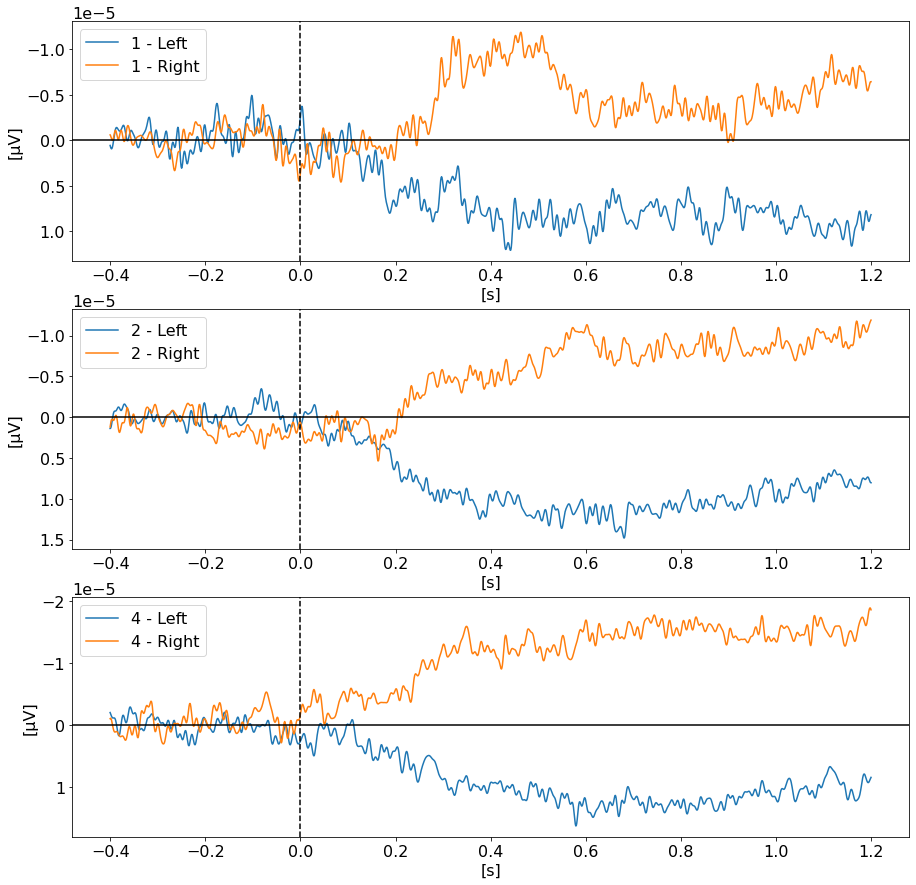

In [64]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 1, figsize=(15,15))

# 2. Plot Figure #1
axs[0].plot(times, cda_all['1']['left'], label='1 - Left')
axs[0].plot(times, cda_all['1']['right'], label='1 - Right')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')

# 2. Plot Figure #2
axs[1].plot(times, cda_all['2']['left'], label='2 - Left')
axs[1].plot(times, cda_all['2']['right'], label='2 - Right')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')

# 2. Plot Figure #2
axs[2].plot(times, cda_all['4']['left'], label='4 - Left')
axs[2].plot(times, cda_all['4']['right'], label='4 - Right')
axs[2].axvline(x=0, color='k', linestyle='--')
axs[2].axhline(y=0, color='k', linestyle='-')
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_ylabel('[μV]')
axs[2].set_xlabel('[s]')

#plt.savefig("./V-2018-Exp1_CDA-reprod.png", dpi=300, format='png')

In [22]:
cda_all = dict()

for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    for f in epochs_dict_all.keys():        
        perf = 'good'
        
        ldata = epochs_dict_all[f][cond]['left'][perf].average().data.mean(0)
        rdata = epochs_dict_all[f][cond]['right'][perf].average().data.mean(0)
                   
        cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
        cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

(1640,)

(14, 307)
(9, 307)
(16, 307)
(11, 307)
(13, 307)
(10, 307)


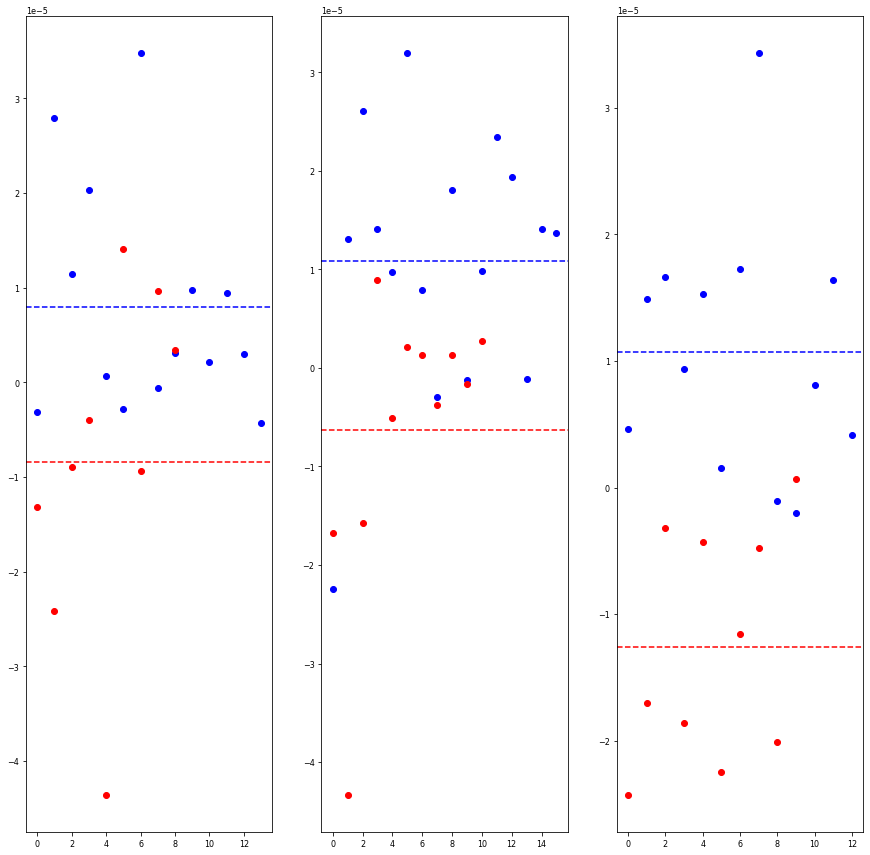

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))

for i, cond in enumerate(conds):
    data_left = epochs_dict_all[f][cond]['left'][perf].get_data().mean(1)[:,(times>0.3) & (times<0.6)]
    print(data_left.shape)

    data_right = epochs_dict_all[f][cond]['right'][perf].get_data().mean(1)[:,(times>0.3) & (times<0.6)]
    print(data_right.shape)

    means_left = [np.mean(data) for data in data_left]
    means_right = [np.mean(data) for data in data_right]

    axs[i].scatter(x=range(len(means_left)), y=means_left, color='blue')
    axs[i].scatter(x=range(len(means_right)), y=means_right, color='red')
    axs[i].axhline(y=np.nanmean(means_right), color='red', linestyle='--')
    axs[i].axhline(y=np.nanmean(means_left), color='blue', linestyle='--')

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_23451/2922498950.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, figsize=(15,5))


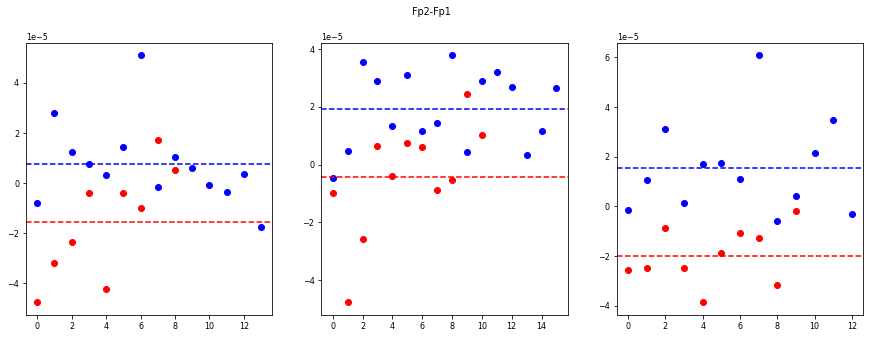

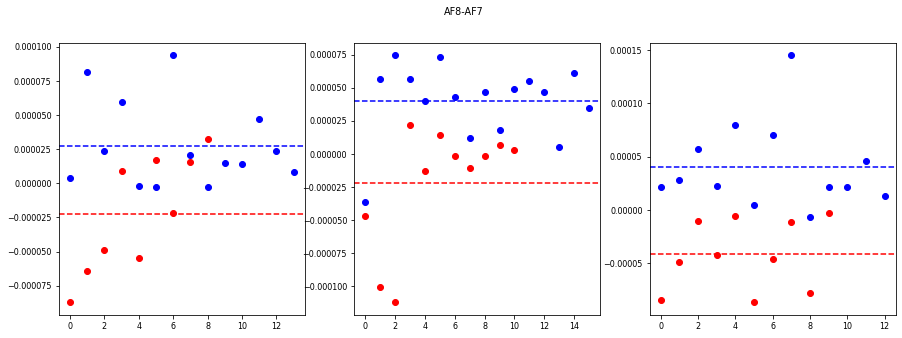

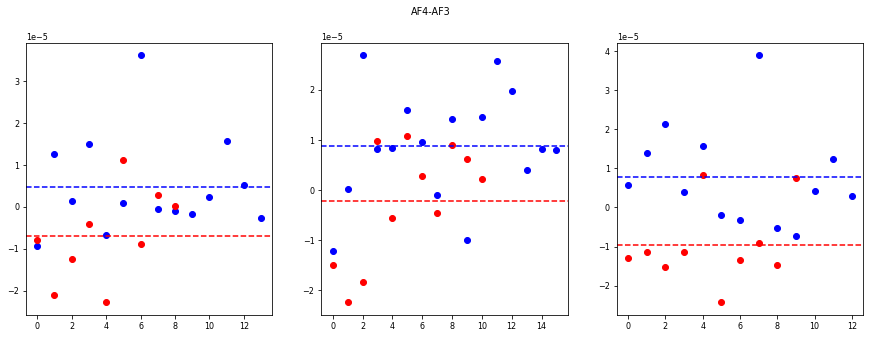

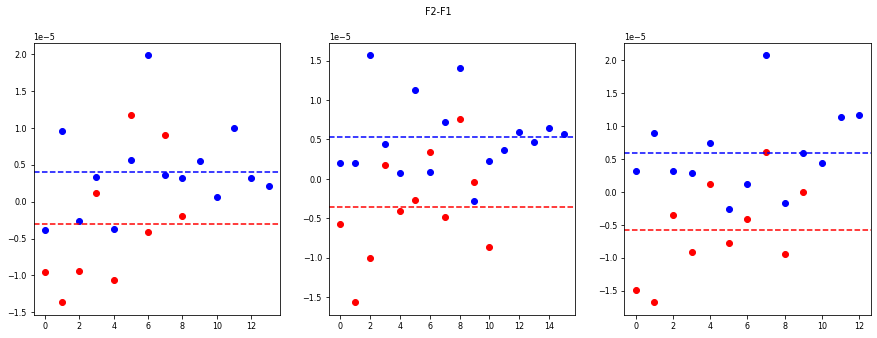

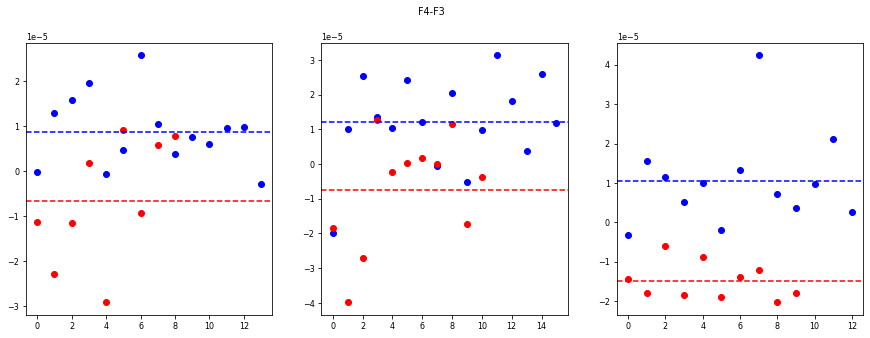

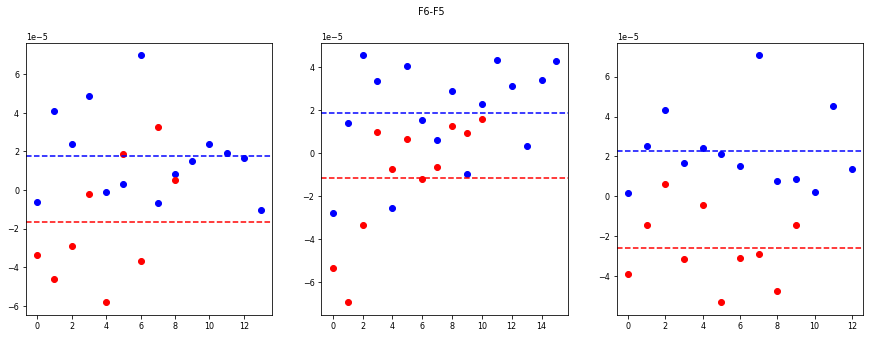

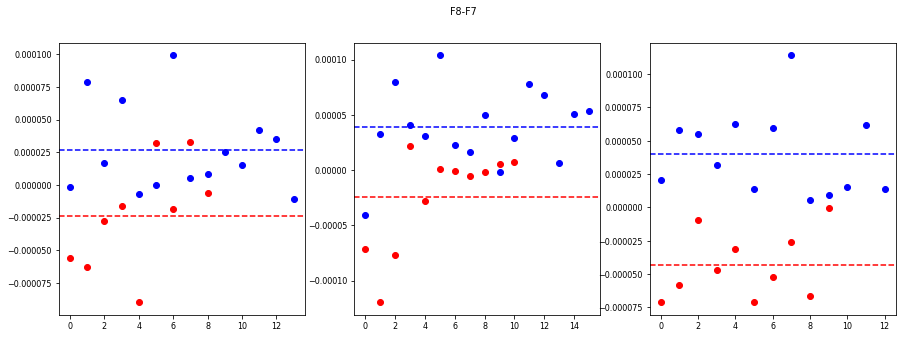

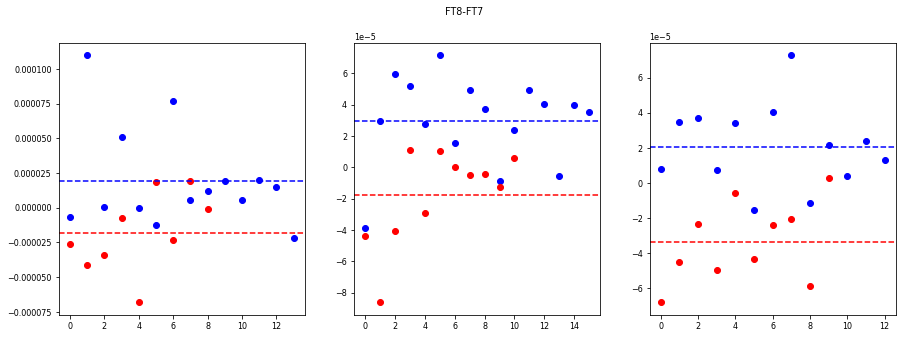

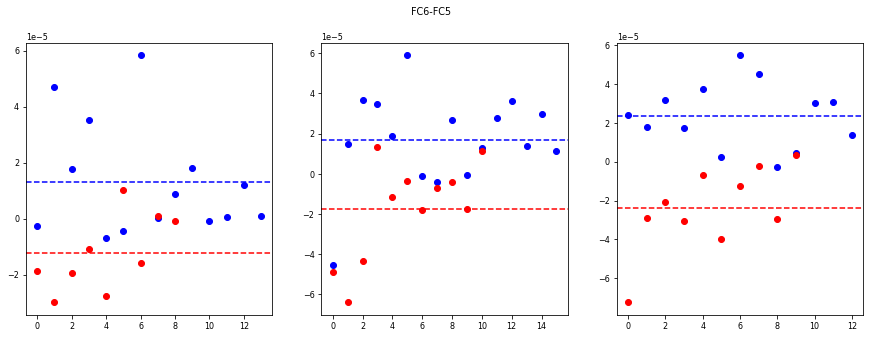

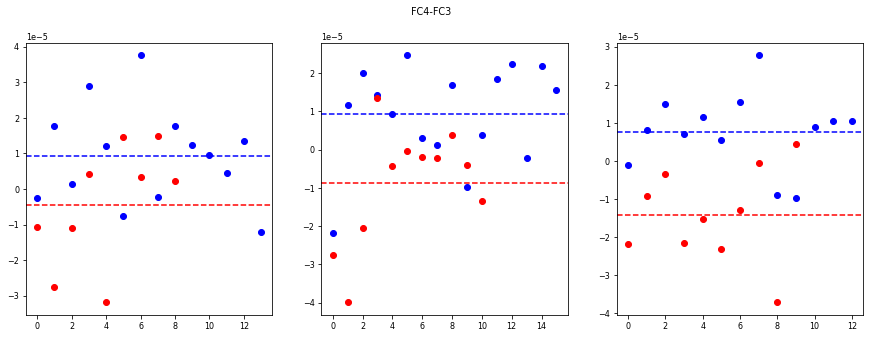

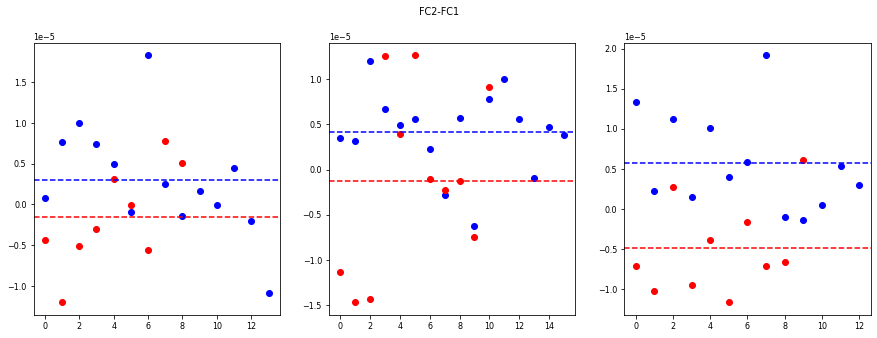

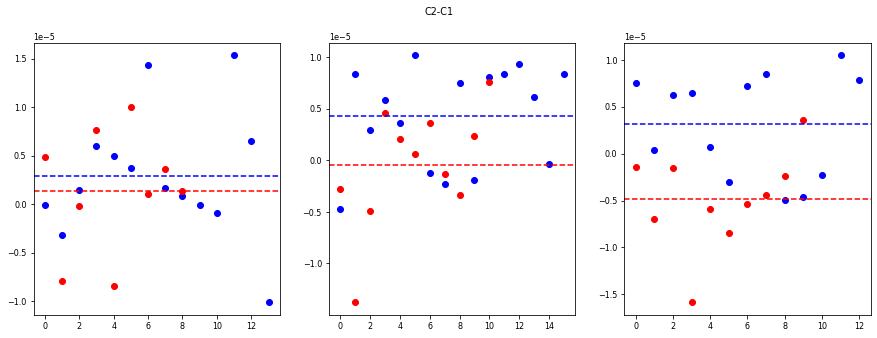

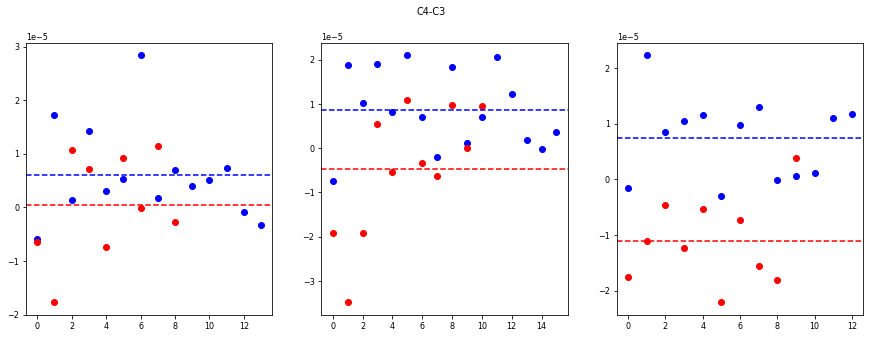

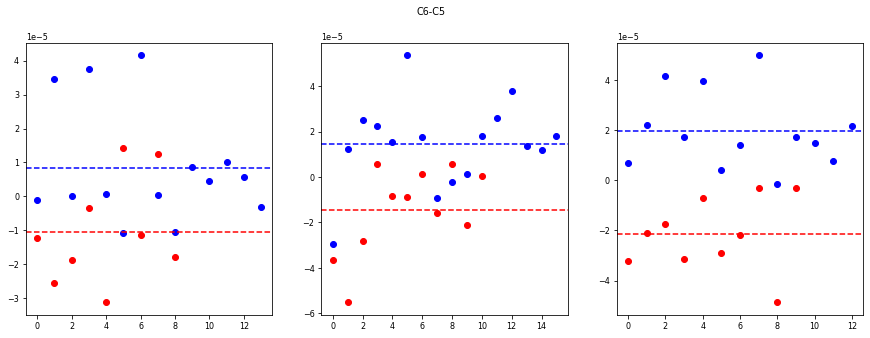

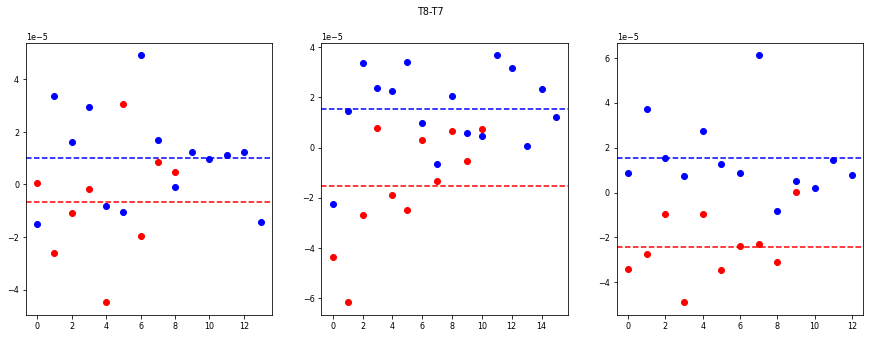

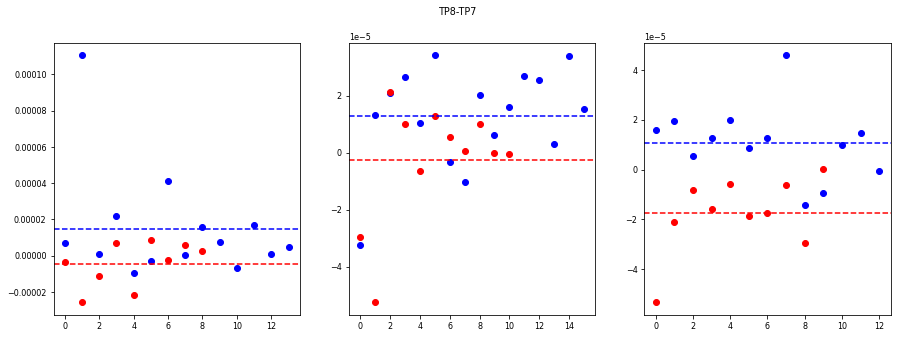

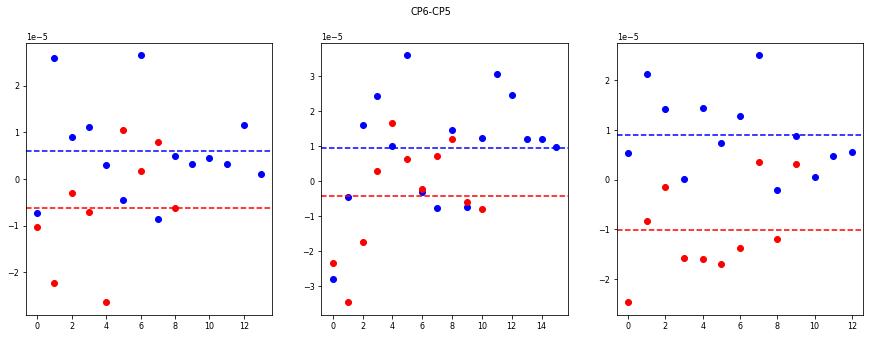

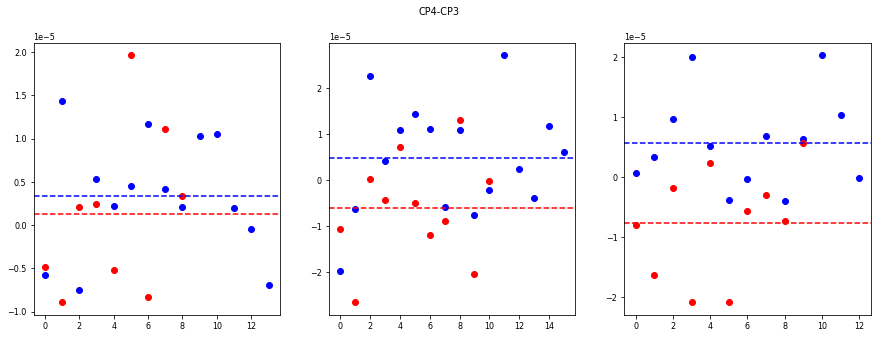

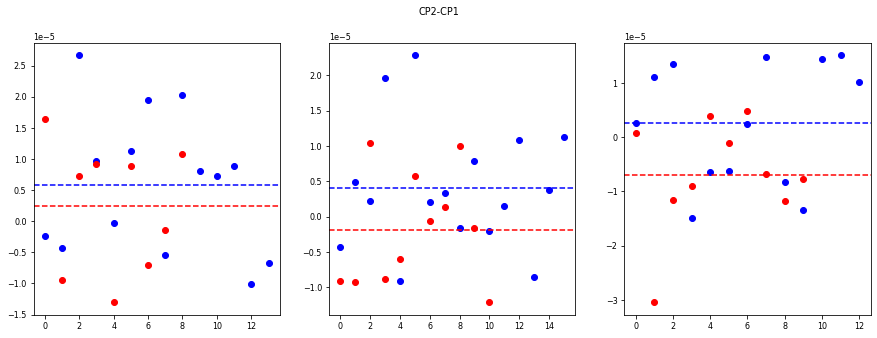

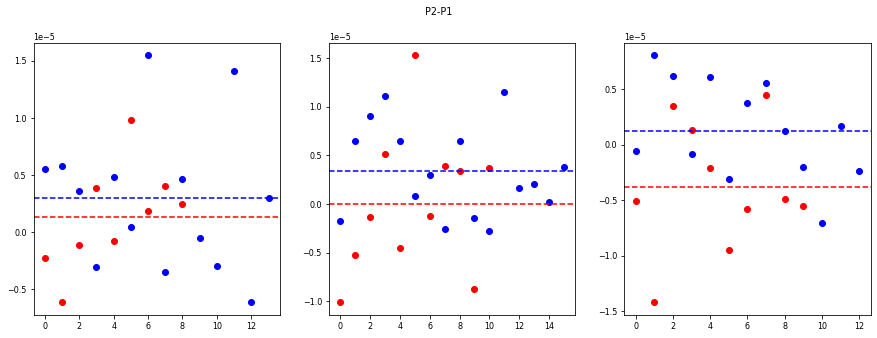

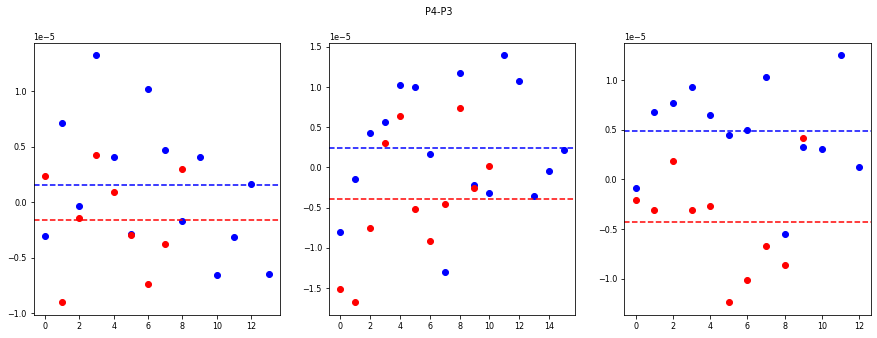

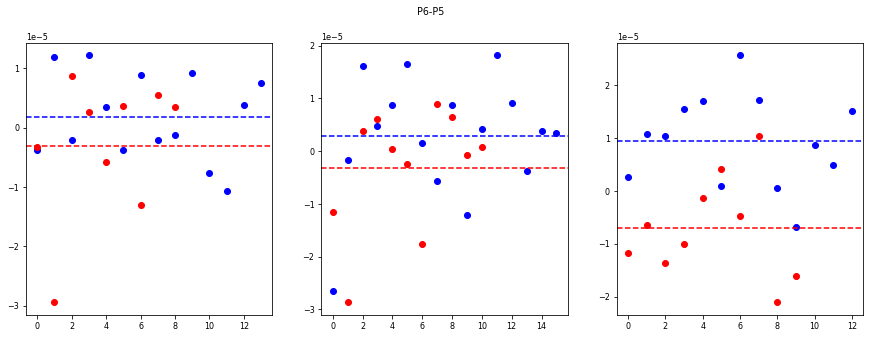

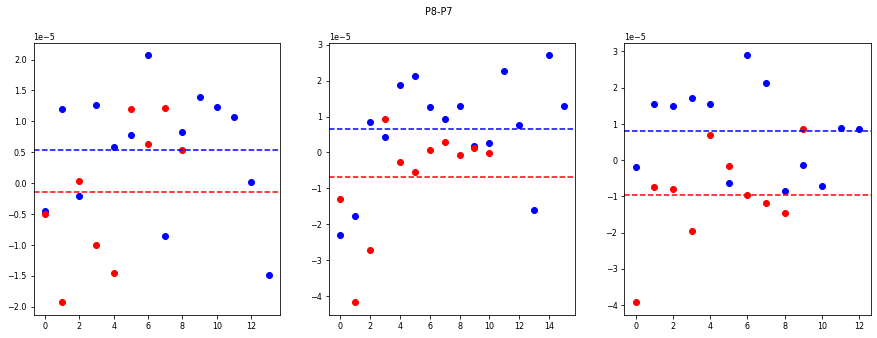

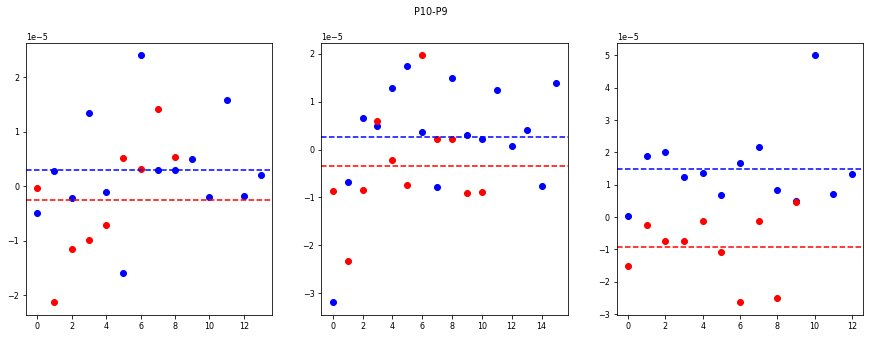

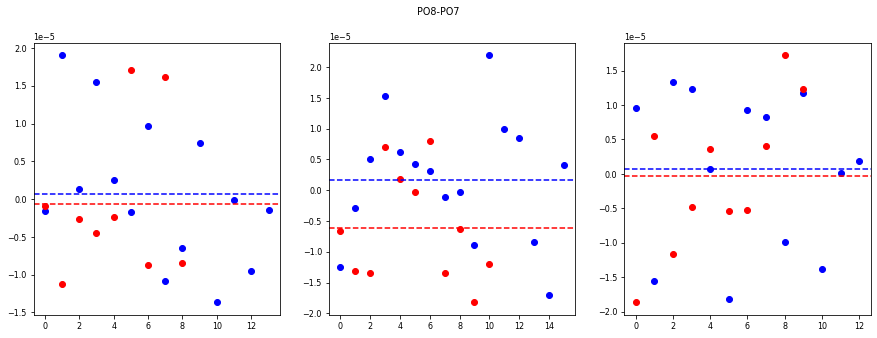

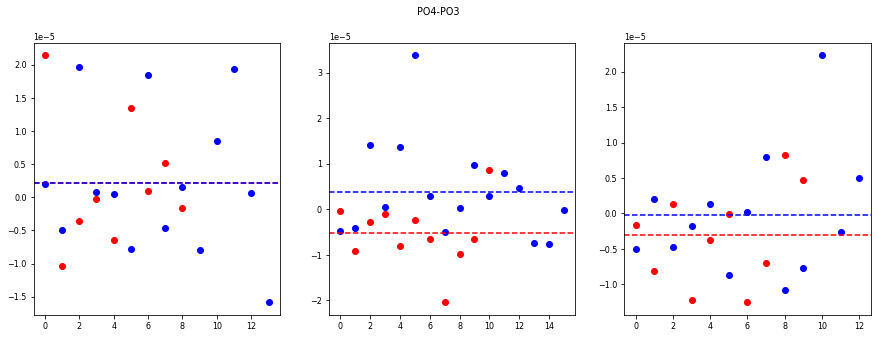

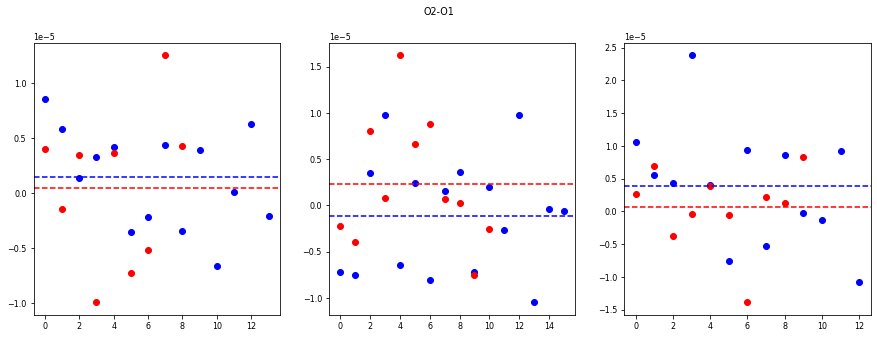

In [68]:
for c, pair in enumerate(chan_pairs):
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(pair)
    for i, cond in enumerate(conds):
        data_left = epochs_dict_all[f][cond]['left'][perf].get_data()[:,c,(times>0.3) & (times<0.9)]
        #print(data_left.shape)

        data_right = epochs_dict_all[f][cond]['right'][perf].get_data()[:,c,(times>0.3) & (times<0.9)]
        #print(data_right.shape)

        means_left = [np.mean(data) for data in data_left]
        means_right = [np.mean(data) for data in data_right]

        axs[i].scatter(x=range(len(means_left)), y=means_left, color='blue')
        axs[i].scatter(x=range(len(means_right)), y=means_right, color='red')
        axs[i].axhline(y=np.nanmean(means_right), color='red', linestyle='--')
        axs[i].axhline(y=np.nanmean(means_left), color='blue', linestyle='--')

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_23451/3971432019.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, figsize=(15,4))


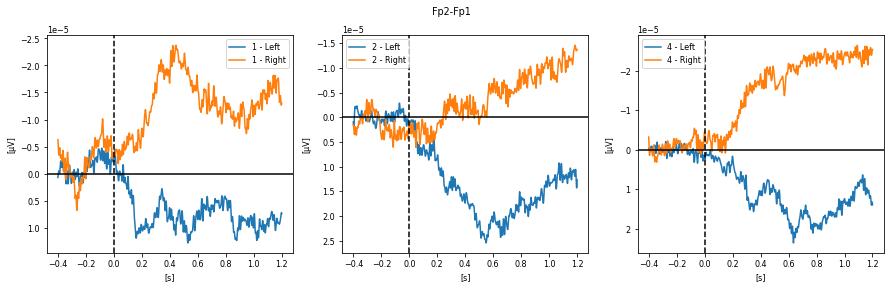

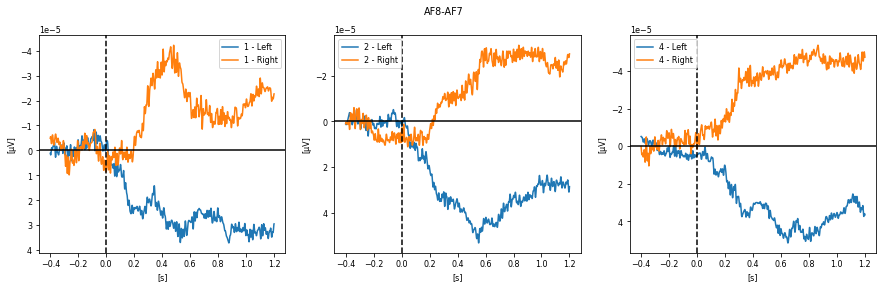

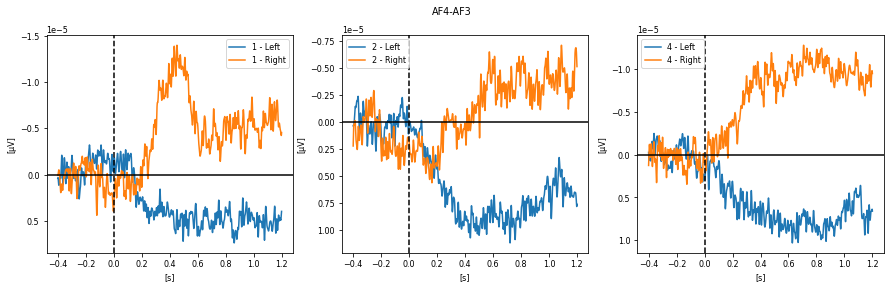

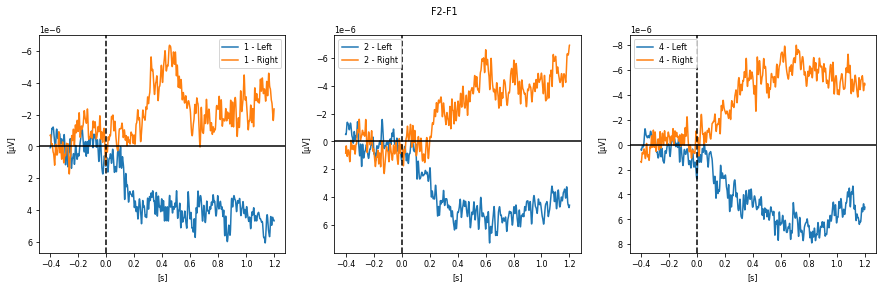

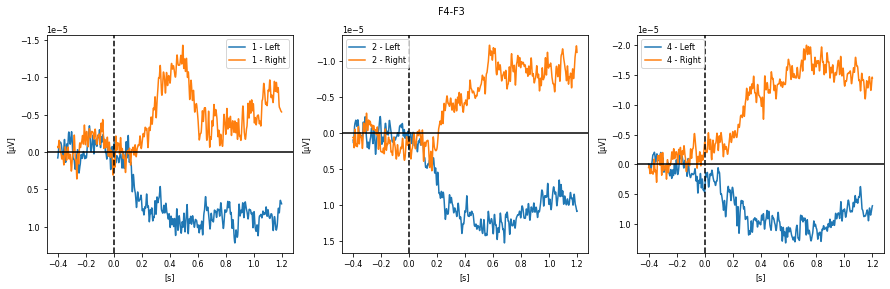

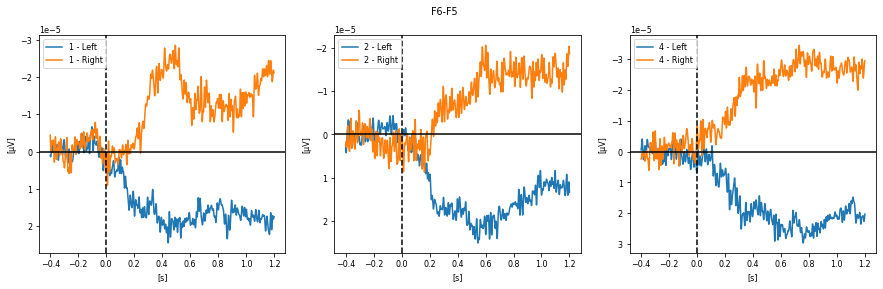

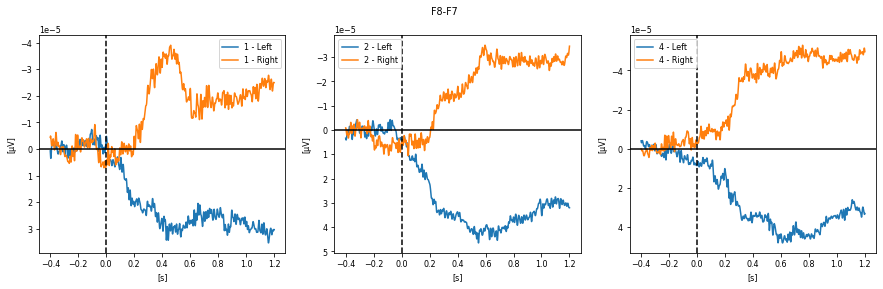

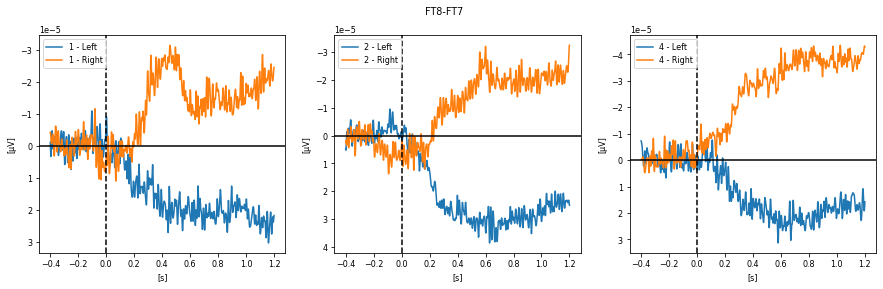

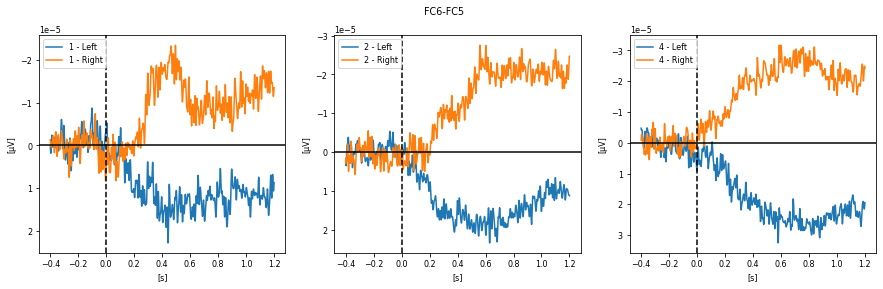

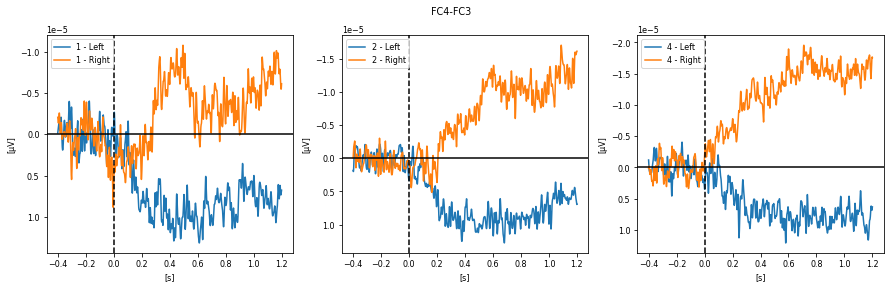

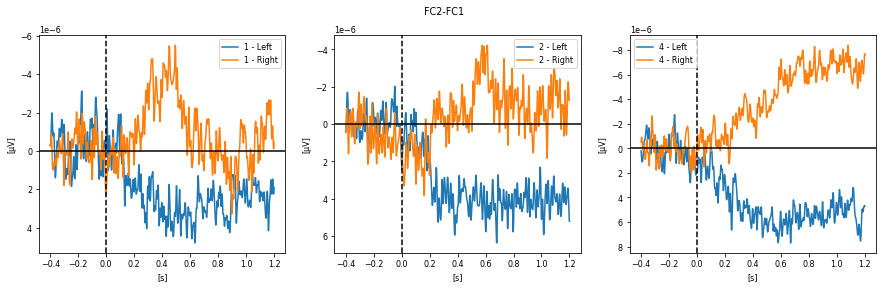

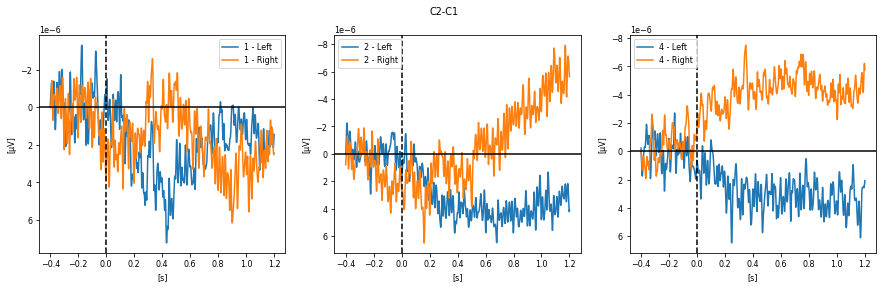

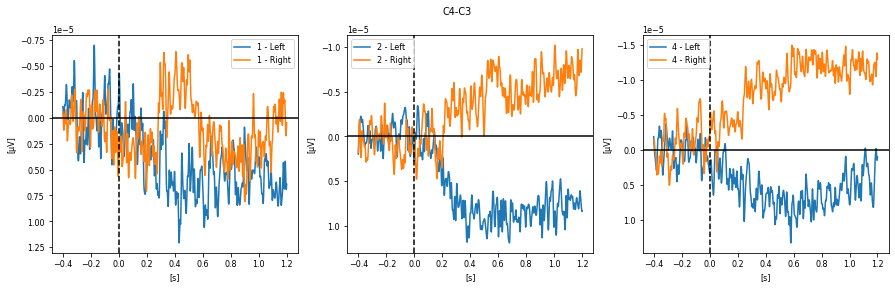

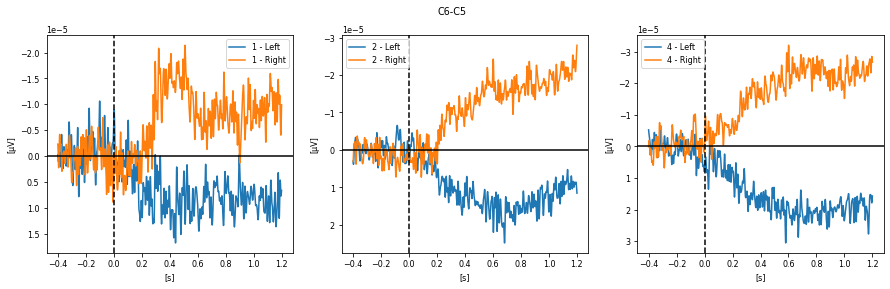

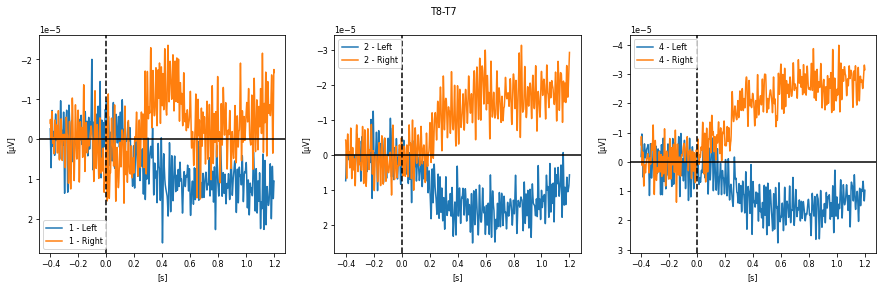

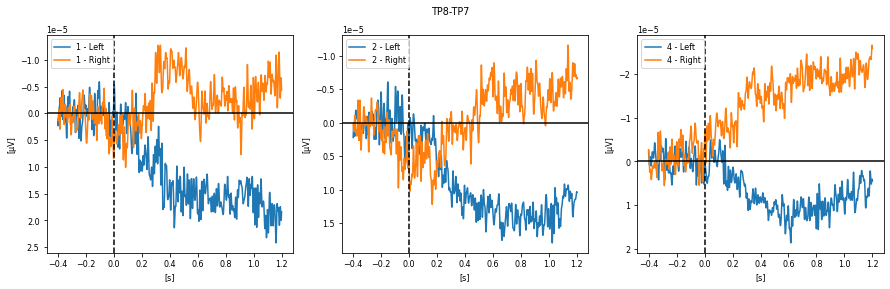

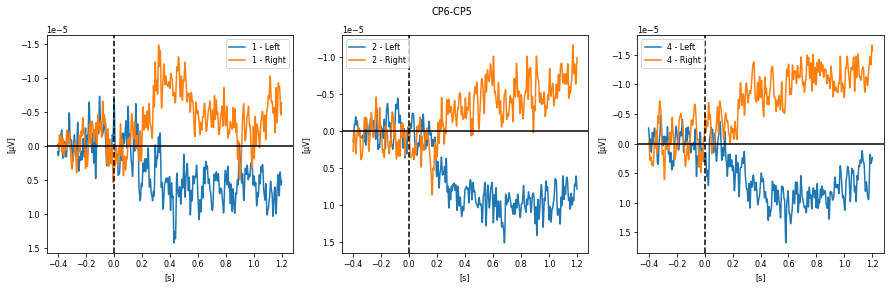

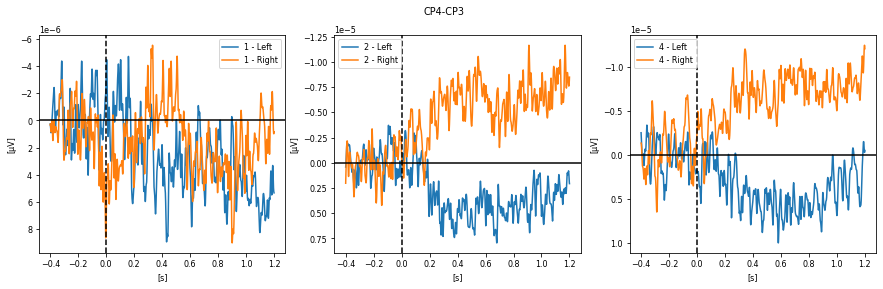

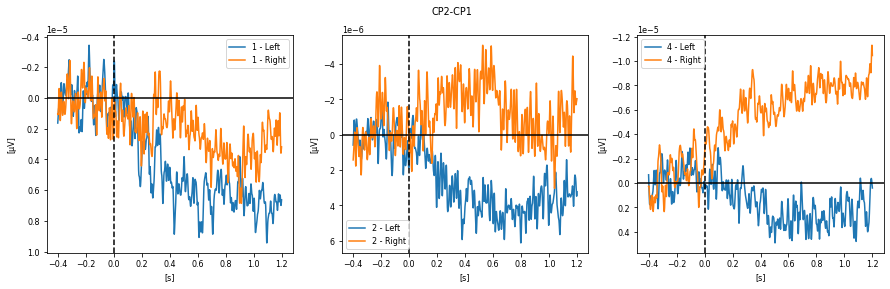

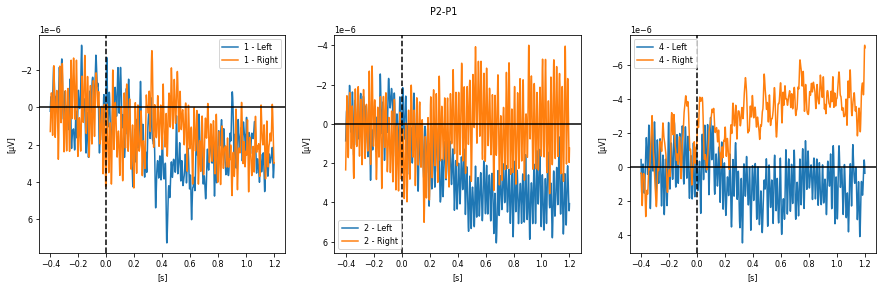

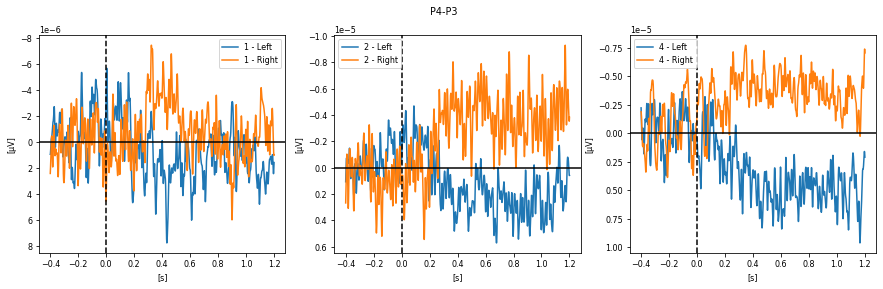

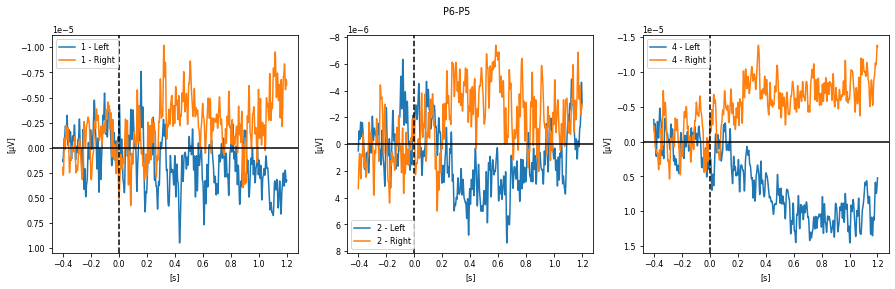

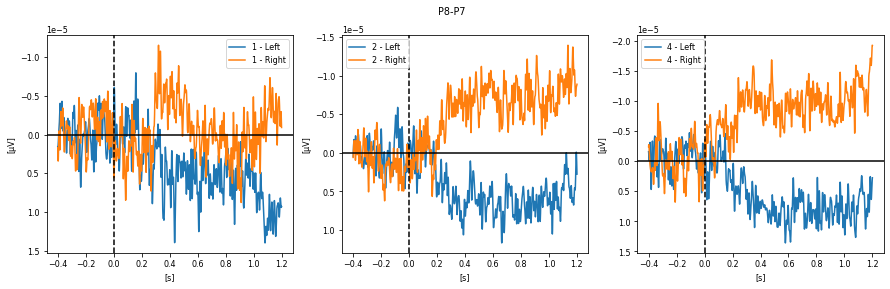

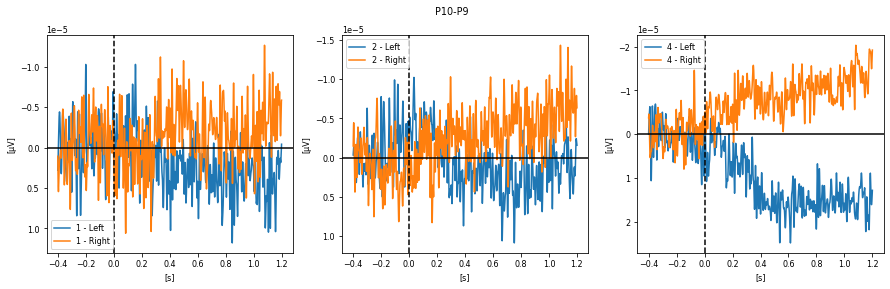

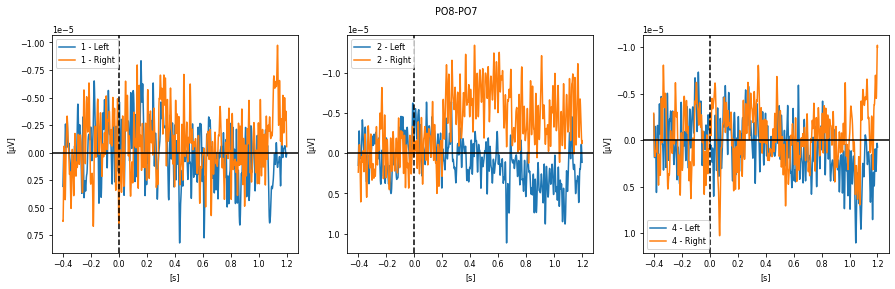

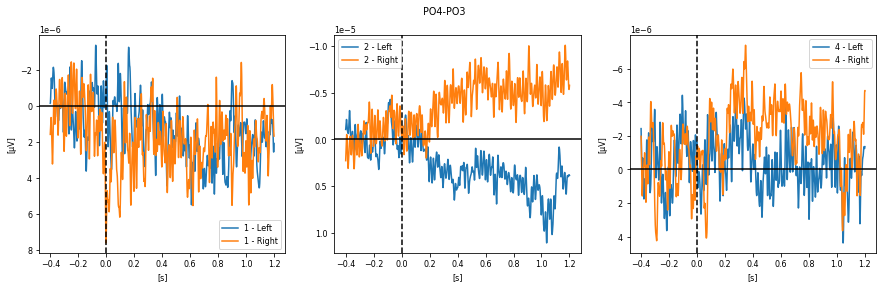

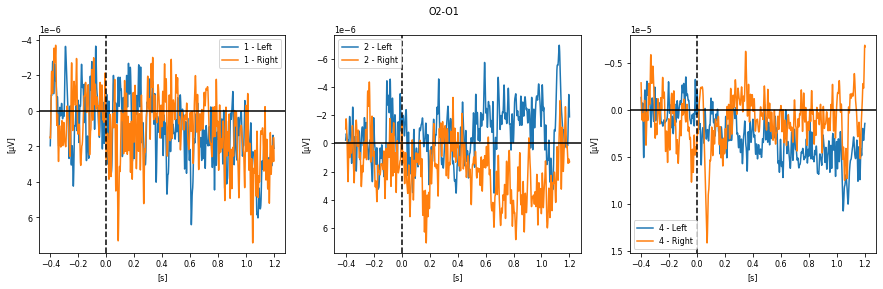

In [65]:
plt.rcParams.update({'font.size': 8})

for c, pair in enumerate(chan_pairs):
    cda_all = dict()
    for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
        cda_all[cond] = dict()
        cda_all[cond]['left'] = np.array([])
        cda_all[cond]['right'] = np.array([])

        for f in epochs_dict_all.keys():        
            perf = 'good'

            ldata = epochs_dict_all[f][cond]['left'][perf].average().data[c,:]
            rdata = epochs_dict_all[f][cond]['right'][perf].average().data[c,:]

            cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
            cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

    fig, axs = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle(pair)

    # 2. Plot Figure #1
    axs[0].plot(times, cda_all['1']['left'], label='1 - Left')
    axs[0].plot(times, cda_all['1']['right'], label='1 - Right')
    axs[0].axvline(x=0, color='k', linestyle='--')
    axs[0].axhline(y=0, color='k', linestyle='-')
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_ylabel('[μV]')
    axs[0].set_xlabel('[s]')

    # 2. Plot Figure #2
    axs[1].plot(times, cda_all['2']['left'], label='2 - Left')
    axs[1].plot(times, cda_all['2']['right'], label='2 - Right')
    axs[1].axvline(x=0, color='k', linestyle='--')
    axs[1].axhline(y=0, color='k', linestyle='-')
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_ylabel('[μV]')
    axs[1].set_xlabel('[s]')

    # 2. Plot Figure #2
    axs[2].plot(times, cda_all['4']['left'], label='4 - Left')
    axs[2].plot(times, cda_all['4']['right'], label='4 - Right')
    axs[2].axvline(x=0, color='k', linestyle='--')
    axs[2].axhline(y=0, color='k', linestyle='-')
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_ylabel('[μV]')
    axs[2].set_xlabel('[s]')

Processing: AP140119.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/AP140119.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 749567  =      0.000 ...   366.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
368 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
368 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 80 Hz

FIR filter parameters
-------------------

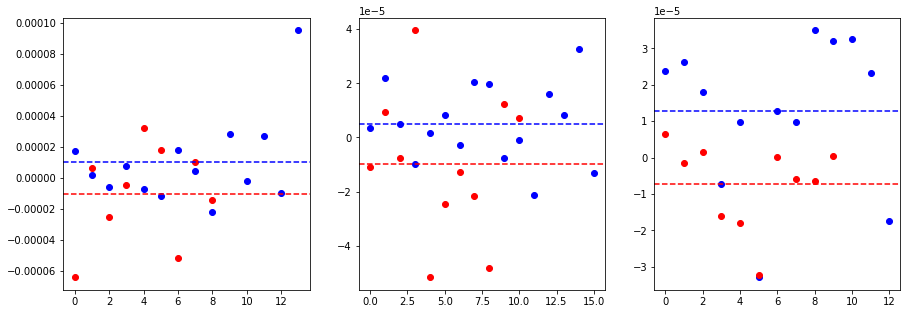

In [5]:
#==================================================================
# General Variables
#==================================================================
study_id = 'Villena2019'

triggers = dict();

triggers['1'] = [10,11,12,13] 
triggers['2'] = [20,21,22,23]
triggers['4'] = [40,41,42,43]

triggers['left'] =  [10,13,20,23,40,43] #[11,12,21,22,41,42]
triggers['right'] = [11,12,21,22,41,42] #[10,13,20,23,40,43]

triggers['good'] = [60]
triggers['bad'] =  [61]
# --------------------------

# Labels
conds = ['1', '2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# Internal Triggers to Epochs Properly
internal_triggers = dict()
internal_triggers_count = 0
for cond in conds:
    for side in sides:
        for perf in perfs:
            internal_triggers_count = internal_triggers_count + 1
            internal_triggers['{}-{}-{}'.format(cond,side,perf)] = internal_triggers_count
            
# CDA Channels
#chan_right = ['AF8', 'F2', 'F8', 'FT8']
#chan_left = ['AF7', 'F1', 'F7', 'FT7']
chan_right = ['AF8', 'F2', 'F8', 'FT8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
chan_left =  ['AF7', 'F1', 'F7', 'FT7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
#chan_left =  ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
#chan_right = ['Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

# Epoch information
epoch_length = 1.2
epoch_tmin = -0.4
baseline_corr = (-0.4, -0.2)

# CDA info
cda_window = (0.3, 0.9)

# CDA main variable!
cda_dict_all = dict()
epochs_dict_all = dict()
perf_report_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Villena-Gonzalez 2019\\Data\\'
directory_path = '/Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/'
sep = '/'

filepath = directory_path + 'AP140119.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind(sep)+1:]
print('Processing: ' + filename + '...')

# ------------------------
# 1. -- Load File --
# ------------------------
raw = read_raw_bdf(filepath, preload=True)

# ------------------------
# 2. -- Preprocessing --
# ------------------------
# Keep only EEG channels and reference
#raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG4','EXG5','EXG6'])
raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])
raw = raw.set_channel_types({'EXG7': 'misc', 'EXG8': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Resample
preproc = raw.resample(1024)

# Filter
preproc = preproc.filter(.1, 80, fir_design='firwin', skip_by_annotation='edge')

# Events
events = find_events(preproc)

# Chan Pairs
#chan_pairs = ['{}-{}'.format(chan_right[i], chan_left[i]) for i, chan in enumerate(chan_right)]

#for i, chan in enumerate(chan_right):
#    preproc = mne.set_bipolar_reference(preproc, anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
    #new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data

preproc = preproc.pick_channels((chan_left + chan_right))

# Plot (visual check)
#preproct.plot...

# ------------------------
# 3. -- Epochs --
# ------------------------
specific_events = get_specific_events(events, conds, sides, perfs, triggers, internal_triggers)

epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr, clean=False)

epochs_dict_all[filename] = epochs_dict

# times, used for CDA mean amp report.
times = epochs_dict[conds[0]][sides[0]][perfs[0]].times

# ------------------------
# - Report & Checksum -
# ------------------------
report = fill_report(report, filename, specific_events)
report

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, cond in enumerate(conds):
    perf = 'good'
    data_left = epochs_dict_all[filename][cond]['left'][perf].get_data().mean(1)[:,(times>0.3) & (times<0.6)]
    #print(data_left.shape)

    data_right = epochs_dict_all[filename][cond]['right'][perf].get_data().mean(1)[:,(times>0.3) & (times<0.6)]
    #print(data_right.shape)

    means_left = [np.mean(data) for data in data_left]
    means_right = [np.mean(data) for data in data_right]

    axs[i].scatter(x=range(len(means_left)), y=means_left, color='blue')
    axs[i].scatter(x=range(len(means_right)), y=means_right, color='red')
    axs[i].axhline(y=np.nanmean(means_right), color='red', linestyle='--')
    axs[i].axhline(y=np.nanmean(means_left), color='blue', linestyle='--')

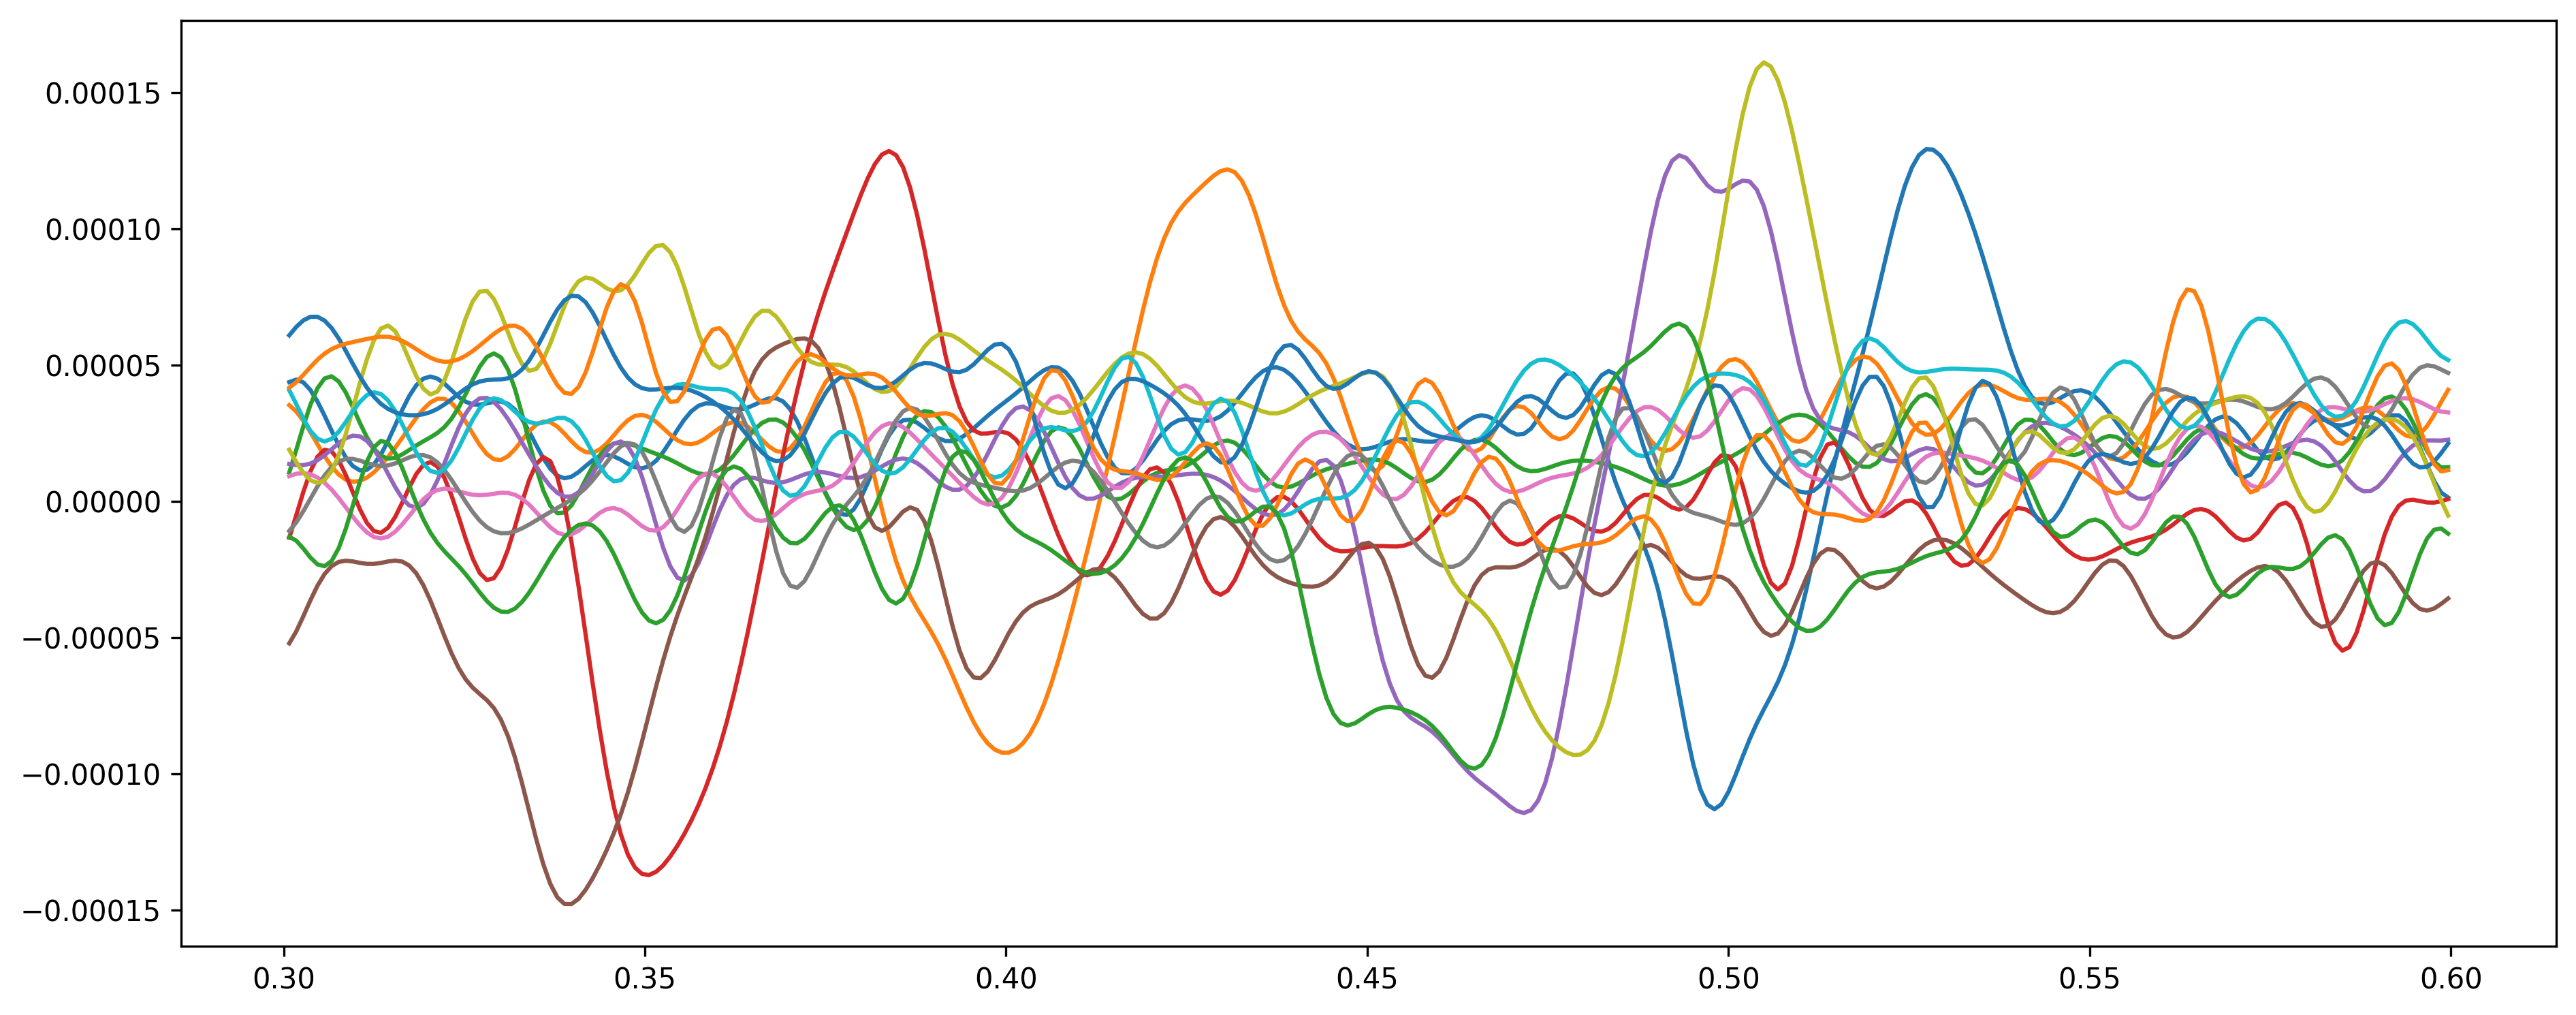

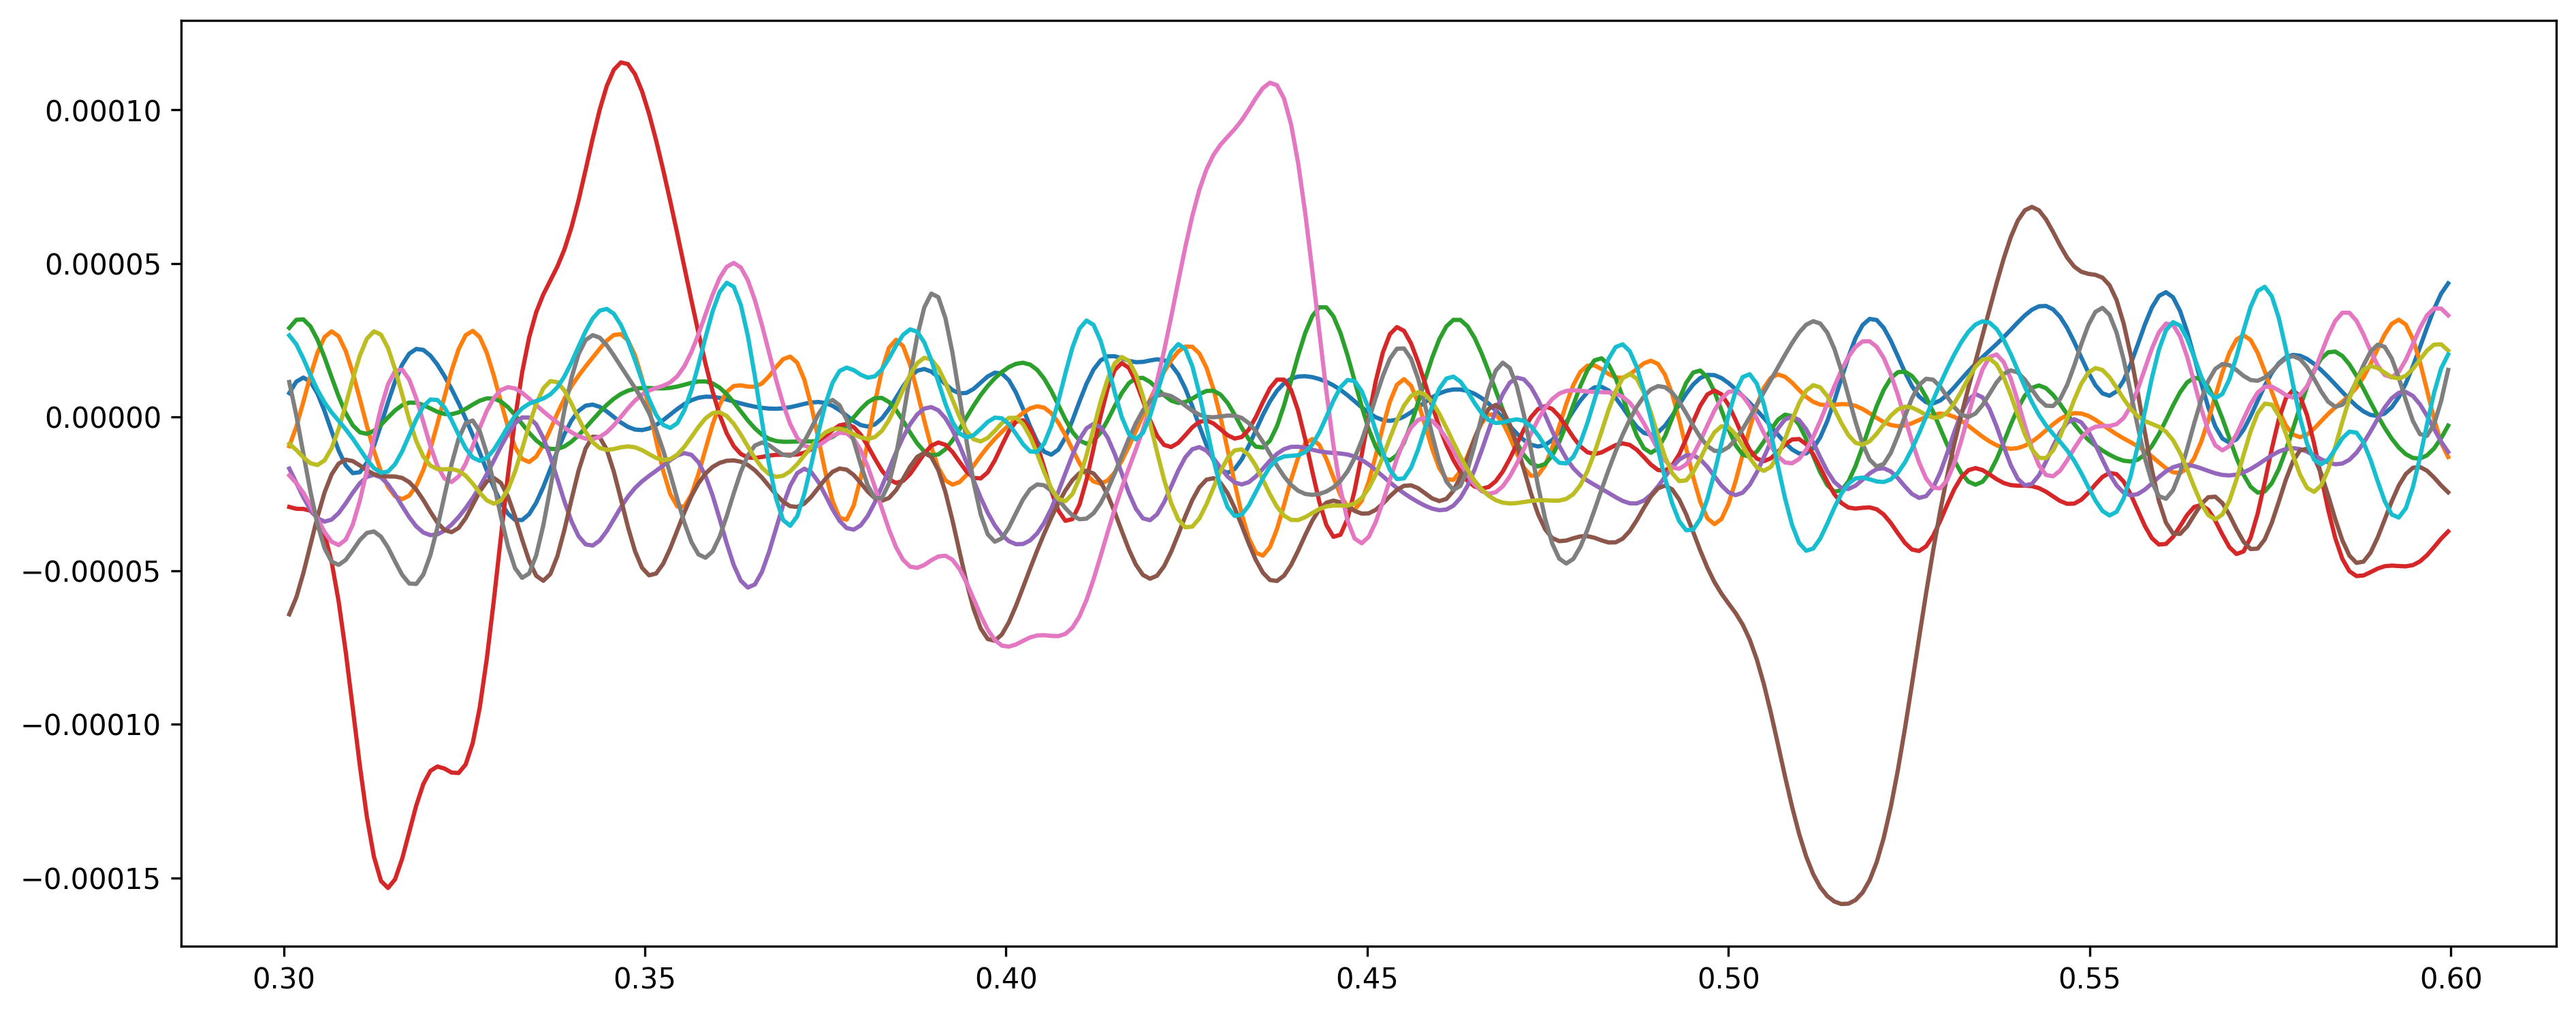

In [6]:
#fig, axs = plt.subplots(1, 3, figsize=(15,15))

#for i, cond in enumerate(conds):
cond = '4'
perf = 'good'
side = 'left'
sub_times = times[(times>0.3) & (times<0.6)]
data = epochs_dict_all[filename][cond][side][perf].get_data().mean(1)[:,(times>0.3) & (times<0.6)]

plt.figure(figsize=(15, 6), dpi=300)
for y in data:
    plt.plot(sub_times, y)
plt.show()

cond = '4'
perf = 'good'
side = 'right'
sub_times = times[(times>0.3) & (times<0.6)]
data = epochs_dict_all[filename][cond][side][perf].get_data().mean(1)[:,(times>0.3) & (times<0.6)]

plt.figure(figsize=(15, 6), dpi=300)
for y in data:
    plt.plot(sub_times, y)
plt.show()

    #axs[i].scatter(x=range(len(means_left)), y=means_left, color='blue')
    #axs[i].scatter(x=range(len(means_right)), y=means_right, color='red')
    #axs[i].axhline(y=np.nanmean(means_right), color='red', linestyle='--')
    #axs[i].axhline(y=np.nanmean(means_left), color='blue', linestyle='--')

# MACHINE LEARNING

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM


###################################################################################################
# Classfication
# ----------------------------

clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
#clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[0,1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

#clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
#clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

#clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
#clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
perf = 'good'
filename = 'AP140119.bdf'
#X_2_left = epochs_dict_all[filename]['2']['left'][perf].get_data().mean(1)* 1e6
#X_4_left = epochs_dict_all[filename]['4']['left'][perf].get_data().mean(1)* 1e6
#X_2_right = epochs_dict_all[filename]['2']['right'][perf].get_data().mean(1)* 1e6
#X_4_right = epochs_dict_all[filename]['4']['right'][perf].get_data().mean(1)* 1e6

X_2_left = epochs_dict_all[filename]['2']['left'][perf].get_data() * 1e6
X_4_left = epochs_dict_all[filename]['4']['left'][perf].get_data() * 1e6
X_2_right = epochs_dict_all[filename]['2']['right'][perf].get_data() * 1e6
X_4_right = epochs_dict_all[filename]['4']['right'][perf].get_data() * 1e6

X = [] #* 1e6
y = []
for x in X_2_left: 
    X.append(x)
    y.append(0)
for x in X_4_left: 
    X.append(x)
    y.append(0)
for x in X_2_right: 
    X.append(x)
    y.append(1)
for x in X_4_right: 
    X.append(x)
    y.append(1)

X = np.array(X)
y = np.array(y)
times = epochs_dict_all[filename]['2']['right'][perf].times

print('X: {}   |   y: {}  '.format(X.shape, y.shape))

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==0, scoring='roc_auc', cv=cv, n_jobs=1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 1)
sns.despine()

X: (50, 32, 1640)   |   y: (50,)  


In [ ]:
from sklearn.model_selection import train_test_split
from pyriemann.embedding import Embedding

event_id = dict(left=0, right=1)

# %%
nfilter = 2
xdwn = XdawnCovariances(estimator='scm', nfilter=nfilter)
split = train_test_split(X, y, train_size=0.25, random_state=42)
Xtrain, Xtest, ytrain, ytest = split
covs = xdwn.fit(Xtrain, ytrain).transform(Xtest)

lapl = Embedding(metric='riemann', n_components=2)
embd = lapl.fit_transform(covs)

# %%
fig, ax = plt.subplots(figsize=(7, 8), facecolor='white')

for cond, label in event_id.items():
    idx = (ytest == label)
    ax.scatter(embd[idx, 0], embd[idx, 1], s=36, label=cond)

ax.set_xlabel(r'$\varphi_1$', fontsize=16)
ax.set_ylabel(r'$\varphi_2$', fontsize=16)
ax.set_title('Spectral embedding of ERP recordings', fontsize=16)
ax.set_xticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.set_yticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.grid(False)
ax.legend()
plt.show()

In [120]:
experiences = ['Exp1a', 'Exp1b', 'Exp2a', 'Exp2b'] 

eegfiles = []
for cur_exp in experiences:
    folderpath = '/Volumes/Nick - Data/CDA Datasets/Hakim 2019/{}/EEGData/**/*.vhdr'.format(cur_exp)
    for filepath in glob.glob(folderpath, recursive=True):
        eegfiles.append(filepath)

for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

Processing: 10_WM_att_NHKA.vhdr...
Processing: 11_WM_att_NHKA.vhdr...
Processing: 12_WM_att_NHKA.vhdr...
Processing: 13_WM_att_NHKA.vhdr...
Processing: 15_WM_att_NHKA.vhdr...
Processing: 16_WM_att_NHKA.vhdr...
Processing: 17_WM_att_NHKA.vhdr...
Processing: 18_WM_att_NHKA.vhdr...
Processing: 20_WM_att_NHKA.vhdr...
Processing: 21_WM_att_NHKA.vhdr...
Processing: 22_WM_att_NHKA.vhdr...
Processing: 23_WM_att_NHKA.vhdr...
Processing: 24_WM_att_NHKA.vhdr...
Processing: 25_WM_att_NHKA.vhdr...
Processing: 28_WM_att_NHKA.vhdr...
Processing: 29_WM_att_NHKA.vhdr...
Processing: 31_WM_att_NHKA.vhdr...
Processing: 34_WM_att_NHKA.vhdr...
Processing: 35_WM_att_NHKA.vhdr...
Processing: 36_WM_att_NHKA.vhdr...
Processing: 38_WM_att_NHKA.vhdr...
Processing: 39_WM_att_NHKA.vhdr...
Processing: 4_WM_att_NHKA.vhdr...
Processing: 42_WM_att_NHKA.vhdr...
Processing: 5_WM_att_NHKA.vhdr...
Processing: 6_WM_att_NHKA.vhdr...
Processing: 7_WM_att_NHKA.vhdr...
Processing: 9_WM_att_NHKA.vhdr...
Processing: 11_WM_att_V2_

In [2]:
import os 
directory_path = '/Volumes/Nick - Data/CDA Datasets/Hakim 2020/Experiment 1/EegData/'

eegfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(directory_path)
    for f in files if f.endswith('.vhdr')]

for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

Processing: Int1_2017.vhdr...
Processing: 10_Int1_2017.vhdr...
Processing: 11_Int1_2017.vhdr...
Processing: 12_Int1_2017.vhdr...
Processing: 13_Int1_2017.vhdr...
Processing: 14_Int1_2017.vhdr...
Processing: 15_Int1_2017.vhdr...
Processing: 16_Int1_2017.vhdr...
Processing: 17_Int1_2017.vhdr...
Processing: 18_Int1_2017.vhdr...
Processing: 19_Int1_2017.vhdr...
Processing: 1b_Int1_2017.vhdr...
Processing: 2_Int1_2017.vhdr...
Processing: 20_Int1_2017.vhdr...
Processing: 21_Int1_2017.vhdr...
Processing: 3_Int1_2017.vhdr...
Processing: 4_Int1_2017.vhdr...
Processing: 5_Int1_2017.vhdr...
Processing: 6_Int1_2017.vhdr...
Processing: 7_Int1_2017.vhdr...
Processing: 8_Int1_2017.vhdr...
Processing: 9_Int1_2017.vhdr...


In [ ]:
# TODO - User 'condition/side' epoch dict strucutre!
# see: https://www.youtube.com/watch?v=t-twhNqgfSY&t=65s&ab_channel=MRCCBU
#        at 2h52m00